Name : Munasinghe M.M.R.H.

Index Number : 190399L

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

([], [])

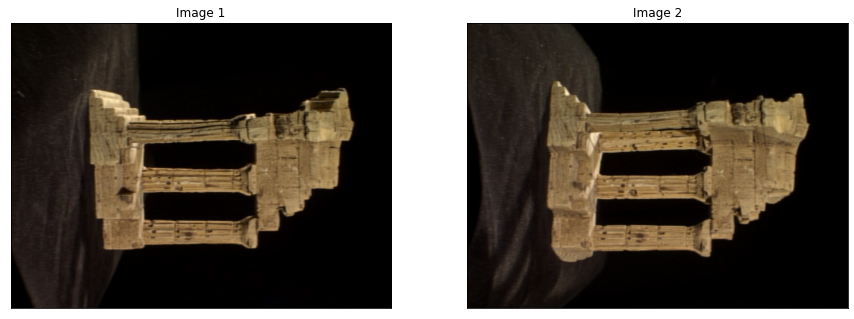

In [4]:
f = open(r'./templeSR_par.txt','r')
assert f is not None

n = int(f.readline())
l = f.readline().split()
im1_fn = l[0]
#1st image
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#2nd image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

im1 =  cv.imread(r'./'+im1_fn , cv.IMREAD_COLOR)
im2 =  cv.imread(r'./'+ im2_fn , cv.IMREAD_COLOR)
assert im1 is not None
assert im2 is not None
fig , ax =  plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].set_title('Image 1')
ax[0].set_xticks([]), ax[0].set_yticks([])

ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].set_title('Image 2')
ax[1].set_xticks([]), ax[1].set_yticks([])



Fundamental Matrix : [[ 1.49034037e-06  1.44154168e-05 -2.53948320e-02]
 [-8.25788252e-06  8.67005344e-08  4.00767127e-03]
 [ 2.27526901e-02 -7.28270380e-03  1.00000000e+00]]
Essential Matrix : [[ 3.44509489e+00  3.34434549e+01 -3.25145725e+01]
 [-1.91581088e+01  2.01870994e-01  2.33852108e+00]
 [ 3.21786978e+01 -4.43004055e+00 -6.22266684e-03]]
Cameras Matrix : [[ 1.58524669e+02  1.53324446e+03 -1.64453374e+02 -9.53099575e+02]
 [ 1.53407871e+03 -1.25194936e+02 -1.42282633e+02  4.27897189e+01]
 [ 7.55162306e-02  8.27859886e-02 -9.93702057e-01  6.49896959e-01]]


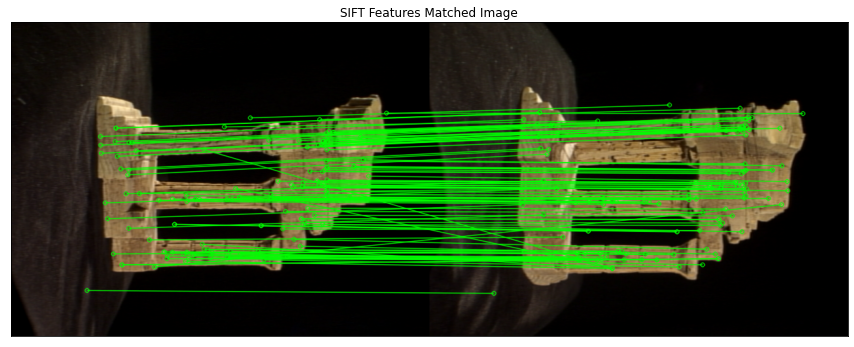

In [23]:
#Ques 1 
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.array(pts1)
pts2 = np.array(pts2)

matchesMask = [[0,0] for i in range(len(matches))]

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
im3 = cv.drawMatchesKnn(im1,kp1,im2,kp2,matches,None,**draw_params)

fig , ax =  plt.subplots(figsize=(15,15))
ax.imshow(cv.cvtColor(im3, cv.COLOR_BGR2RGB))
ax.set_title('SIFT Features Matched Image')
ax.set_xticks([]), ax.set_yticks([])

#Ques 2 
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)
E = K2.T@F@K1

print("Fundamental Matrix :",F)
print("Essential Matrix :",E)

#Ques 3 
retval,R,t,mask = cv.recoverPose(E,pts1,pts2,K1)

R_t_1 = np.concatenate((R1,t1),axis=1)

R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_,t2_),axis = 1)

P1 = K1 @ np.hstack((R1,t1))

#Ques 4 
P2_=K2@R_t_2
print("Cameras Matrix :",P2_)

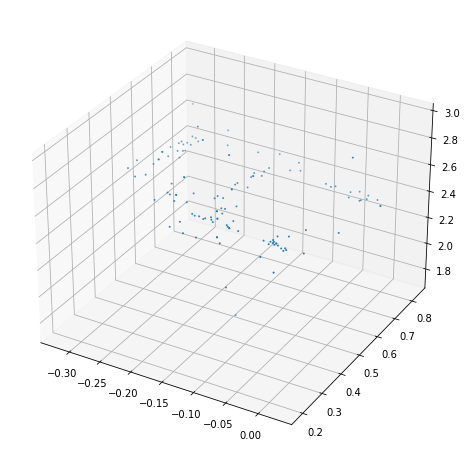

In [12]:
#Ques 5
points4d = cv.triangulatePoints(P1,P2_,pts1.T,pts2.T)
points4d /= points4d[3,:]

X = points4d[0,:]
Y = points4d[1,:]
Z = points4d[2,:]

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(X,Y,Z,s=1,cmap ='gray')
plt.show()